In [1]:
%pylab inline
from matplotlib import pyplot as plt
from workflow.data import *
from workflow.features import *
import pandas as pd
import numpy as np
import seaborn as sns

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

plt.tight_layout
plt.rcParams.update({'font.size': 22})
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
figure(figsize(10,7))

Populating the interactive namespace from numpy and matplotlib


In [2]:
# connect to SQL database

username = 'psam071'
host = 'localhost'
dbname = 'citibike'

db = create_engine('postgres://%s%s/%s' % (username,host,dbname))
con = None

con = psycopg2.connect(database = dbname, user = username, host = host)

# Querying Data and transforming it

In [3]:
# query stations from 2015 that existed at the beginning of the data
# collecting period
query_stations2015 = """
    SELECT DISTINCT a.id, name, lat, long, neighborhood, borough
    FROM features a
    LEFT JOIN stations b ON a.id = b.id
    LEFT JOIN neighborhoods c on a.id = c.id
    WHERE a.date = '2015-03-01'
        --AND tot_docks > 0
        AND borough = 'Manhattan'
    ORDER BY a.id;
"""

stations2015 = pd.read_sql_query(query_stations2015, con)
stations2015 = stations2015.dropna()

In [32]:
stations2015[stations2015.id == 494]

,id,name,lat,long,neighborhood,borough
171,494.0,W 26 St & 8 Ave,40.747348,-73.997236,Chelsea,Manhattan


In [18]:
stations2015.shape

(221, 6)

In [68]:
# most unbalanced stations
query_unbal_stations = """
    SELECT a.id, abs(a.bikes_in - a.bikes_out) as flux,
                 abs(a.rbikes_in - a.rbikes_out) as rflux,
                 a.bikes_in, a.bikes_out,                                 
            c.name, neighborhood, borough, long, lat
    FROM   (SELECT id, sum(bikes_out) as bikes_out, sum(bikes_in) as bikes_in,
                sum(rbikes_in) as rbikes_in, sum(rbikes_out) as rbikes_out
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    ORDER BY rflux DESC
"""

df_unbal_stations = pd.read_sql_query(query_unbal_stations, con)
df_unbal_stations = df_unbal_stations[df_unbal_stations.id.isin(stations2015.id)]
# pl = df_unbal_stations.head(20).plot(kind = 'barh', x = 'name', y = 'flux', stacked=True)
# pl.invert_yaxis()

In [71]:
# save list of top 100 unbalanced stations to pickle file for webapp
df_unbal_stations.iloc[:100].to_pickle('websitetools/stations.pickle')

In [6]:
def dfcol_into_sqllist(df, col):
    # converts a column in a pandas dataframe into a string for sql queries
    listy = list(df[col].unique())
    listy = listy[0:10]
    return "(" + str(listy)[1:-1] + ")"

string_of_unbal_stations = str(list(df_unbal_stations.id.unique()))[1:-1]
list_of_unbal_stations = list(df_unbal_stations.id)
df_unbal_stations.id.unique().shape

(221,)

In [33]:
# look at the patterns for the rebalanced stations
# make sure tot_docks > 0 (especially when calculating bikes available)

ids_to_see = dfcol_into_sqllist(df_unbal_stations, 'id')
# ids_to_see = '(' + str(['72'])[1:-1] + ')'

query = """
    SELECT a.id, a.date, a.hour, bikes_out, bikes_in, dayofweek, month, is_weekday,
            is_holiday, rbikes_out, rbikes_in, tot_docks, avail_bikes, avail_docks,
            precip, temp, long, lat, neighborhood, borough
    FROM features a
    LEFT JOIN weather b ON a.date = b.date AND a.hour = b.hour
    LEFT JOIN stations c ON a.id = c.id
    LEFT JOIN neighborhoods d ON a.id = d.id
    WHERE a.id in {}
        AND tot_docks > 0
        AND borough = 'Manhattan'
    --WHERE tot_docks > 0
    ORDER BY a.id, a.date, a.hour;
""".format(ids_to_see)

df = pd.read_sql_query(query, con)
df.date = pd.to_datetime(df.date)

,id,date,hour,bikes_out,bikes_in,dayofweek,month,is_weekday,is_holiday,rbikes_out,rbikes_in,tot_docks,avail_bikes,avail_docks,precip,temp,long,lat,neighborhood,borough
0,494.0,2015-03-01,1,0.0,1.0,6.0,3.0,False,False,0.0,0.0,35.0,11.0,23.0,0.000,22.000000,-73.997236,40.747348,Chelsea,Manhattan
1,494.0,2015-03-01,2,0.0,1.0,6.0,3.0,False,False,0.0,0.0,35.0,12.0,22.0,0.000,21.000000,-73.997236,40.747348,Chelsea,Manhattan
2,494.0,2015-03-01,4,0.0,1.0,6.0,3.0,False,False,0.0,0.0,35.0,14.0,21.0,0.000,21.000000,-73.997236,40.747348,Chelsea,Manhattan
3,494.0,2015-03-01,6,1.0,0.0,6.0,3.0,False,False,1.0,0.0,35.0,14.0,20.0,0.000,23.000000,-73.997236,40.747348,Chelsea,Manhattan
4,494.0,2015-03-01,7,0.0,3.0,6.0,3.0,False,False,0.0,0.0,35.0,14.0,20.0,0.000,23.000000,-73.997236,40.747348,Chelsea,Manhattan
5,494.0,2015-03-01,8,1.0,0.0,6.0,3.0,False,False,0.0,0.0,35.0,16.0,18.0,0.000,25.000000,-73.997236,40.747348,Chelsea,Manhattan
6,494.0,2015-03-01,9,6.0,2.0,6.0,3.0,False,False,0.0,0.0,35.0,13.0,21.0,0.000,25.000000,-73.997236,40.747348,Chelsea,Manhattan
7,494.0,2015-03-01,10,7.0,3.0,6.0,3.0,False,False,0.0,0.0,35.0,11.0,24.0,0.000,25.000000,-73.997236,40.747348,Chelsea,Manhattan
8,494.0,2015-03-01,11,4.0,6.0,6.0,3.0,False,False,0.0,0.0,35.0,9.0,25.0,0.000,25.000000,-73.997236,40.747348,Chelsea,Manhattan
9,494.0,2015-03-01,12,0.0,2.0,6.0,3.0,False,False,0.0,0.0,35.0,9.0,25.0,0.000,24.000000,-73.997236,40.747348,Chelsea,Manhattan


In [8]:
# make new features (percentages)`
df = new_features(df)


In [9]:
df.id.unique()

array([ 402.,  415.,  426.,  432.,  477.,  492.,  514.,  517.,  519.,  529.])

In [10]:
df[df.isnull().any(axis = 1)]

,id,date,hour,bikes_out,bikes_in,dayofweek,month,is_weekday,is_holiday,rbikes_out,...,temp,long,lat,neighborhood,borough,tot_docks,flux,pct_avail_bikes,pct_avail_docks,pct_flux


In [11]:
# split data into 2015 (train) and 2016 (test) data
# 
data_cols = ['id', 'long', 'lat', 'hour', 'month', 'dayofweek',
             'is_weekday', 
             'is_holiday', 'precip', 'temp', 'pct_avail_bikes', 
             'pct_avail_docks']#, 'pct_avail_docks']
# df = make_categorical(df, ['id', 'hour', 'month', 'is_weekday', 'is_holiday'])
hist_cols = ['mean_flux', 'yest_flux', 'last_week_flux']

df2015 = df[(df.date.dt.year == 2015)]
df2016 = df[(df.date.dt.year == 2016)]

# Prepare pipeline

### TPOT Regressor

In [14]:
# tpot regressor

from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

# data = df[data_cols + hist_cols].sort_index()
# target = df.pct_flux

# X_train, X_test, y_train, y_test = train_test_split(data, target, 
#                                                     train_size = 0.75, test_size = 0.25)

X_train = df2015[data_cols]
y_train = df2015.pct_flux

X_test = df2016[data_cols]
y_test = df2016.pct_flux


reg = TPOTRegressor(generations=2, population_size = 5, verbosity=2)
reg.fit(X_train, y_train)
pred = tpot.predict(X_test)

Optimization Progress:  67%|██████▋   | 10/15 [02:08<03:11, 38.37s/pipeline]

Generation 1 - Current best internal CV score: 0.0279967764342


Generation 2 - Current best internal CV score: 0.0279967764342

Best pipeline: GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.01, GradientBoostingRegressor__loss=DEFAULT, GradientBoostingRegressor__max_depth=9, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=3, GradientBoostingRegressor__min_samples_split=4, GradientBoostingRegressor__n_estimators=DEFAULT, GradientBoostingRegressor__subsample=0.1)


### RandomForestRegressor

In [ ]:
# from sklearn.ensemble import ExtraTreesRegressor
# X_train = df2015[data_cols + hist_cols]
# y_train = df2015.pct_flux

# X_test = df2016[data_cols + hist_cols]
# y_test = df2016.pct_flux

# reg = ExtraTreesRegressor(min_samples_leaf=11, min_samples_split=3, max_features = 0.85, n_estimators = 100,
#                             n_jobs=-1)
# reg.fit(X_train, y_train)
# pred = reg.predict(X_test)

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = [{'min_samples_leaf': [12, 14, 16],
          'min_samples_split': [6, 8, 10],
          'max_features': [0.85,0.95,1.]}]


X_train = df2015[data_cols]
y_train = df2015.pct_flux#.apply(flux_conditions, 0.15)

X_test = df2016[data_cols]
y_test = df2016.pct_flux#.apply(flux_conditions, 0.15)

# reg = GridSearchCV(RandomForestRegressor(), params, cv=2, scoring = 'neg_mean_squared_error')
reg = RandomForestRegressor(min_samples_leaf=16, min_samples_split=6, max_features = 0.95,
                            n_jobs=-1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)


In [20]:
reg.best_params_

{'max_features': 0.95, 'min_samples_leaf': 16, 'min_samples_split': 6}

In [27]:
X_test.head()

,id,long,lat,hour,month,dayofweek,is_weekday,is_holiday,precip,temp,pct_avail_bikes,pct_avail_docks
5121,402.0,-73.989551,40.740343,2,1.0,4.0,1,0,0.0,36.0,0.016393,0.606557
5122,402.0,-73.989551,40.740343,3,1.0,4.0,1,0,0.0,36.0,0.016393,0.606557
5123,402.0,-73.989551,40.740343,4,1.0,4.0,1,0,0.0,35.0,0.032787,0.622951
5124,402.0,-73.989551,40.740343,5,1.0,4.0,1,0,0.0,35.0,0.032787,0.655738
5125,402.0,-73.989551,40.740343,7,1.0,4.0,1,0,0.0,34.0,0.032787,0.655738


In [ ]:
X_test.shape

In [ ]:
values_to_plot.head()

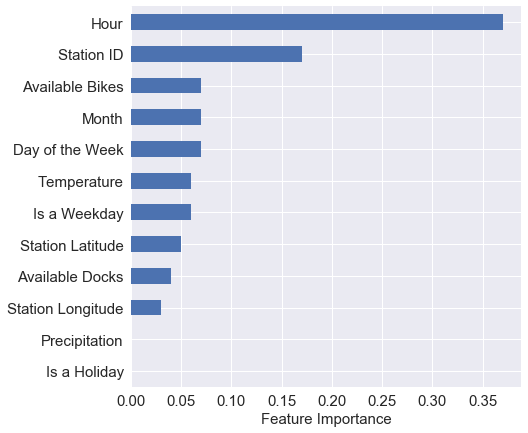

In [30]:
reg.feature_importances_.round(2)
importances = list(reg.feature_importances_.round(2))

features_dict = {}
for importance, col in zip(importances, data_cols):
    features_dict[col] = importance

feature_imp = pd.Series(features_dict)
values_to_plot = feature_imp.sort_values()
values_to_plot.rename(index = {'id':'Station ID',
                                 'hour': 'Hour',
                                 'pct_avail_bikes': 'Available Bikes',
                                 'dayofweek': 'Day of the Week',
                                 'is_weekday': 'Is a Weekday',
                                 'temp': 'Temperature',
                                 'precip': 'Precipitation',
                                'month': 'Month',
                              'lat': 'Station Latitude',
                              'long': 'Station Longitude',
                              'pct_avail_docks': 'Available Docks',
                              'is_holiday': 'Is a Holiday'}, inplace = True)
values_to_plot.plot(kind = 'barh', figsize=(7,7))
xlabel('Feature Importance', fontsize = 15)

In [ ]:
df2015.shape

In [ ]:
stations2015[stations2015.id == 517]

# Test Model

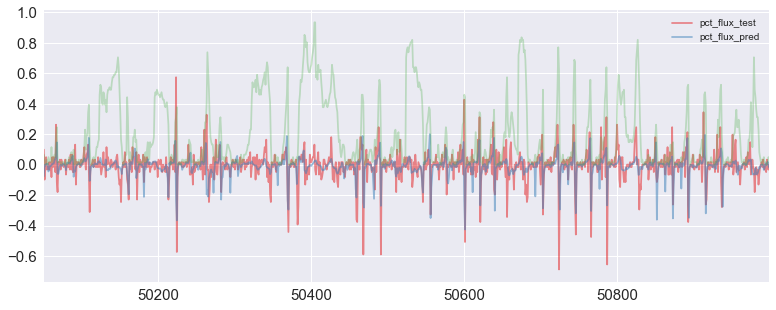

In [31]:
def merge_pred_test(pred, y_test):
    tests = pd.DataFrame()
    tests['pct_flux_test'] = y_test.reset_index().pct_flux
    tests['pct_flux_pred'] = pred
    return tests

def plot_pred_test(test,X_test):
    cmap= sns.color_palette('Set1')
    sns.set_palette(cmap)
    tests.iloc[50050:51000].plot(figsize = (13,5), alpha = 0.5)
    X_test.reset_index().iloc[50050:51000].pct_avail_bikes.plot(alpha = 0.3)
    
   
tests = merge_pred_test(pred, y_test)
# tests.pct_flux_test = tests.pct_flux_test.apply(flux_conditions, 0.2)
# tests.pct_flux_pred = tests.pct_flux_pred.apply(flux_conditions, 0.2)
plot_pred_test(tests, X_test)

In [ ]:
def merge_test_pred(X, y, pred):
    pred_series = pd.Series(pred)
    X = X.reset_index()
    X['pct_flux_test'] = y.reset_index().pct_flux
    X['pct_flux_pred'] = pred_series
    return X

df_compare = merge_test_pred(X_test, y_test, pred)
    

In [ ]:
df_compare.head()

In [ ]:
ids_to_see

In [ ]:
plot_by_hour(df_compare,['pct_flux_test','pct_flux_pred', 'hour'], 477, weekday = 1)
suptitle('Bike Activity for Station {} (Weekday)'.format(477))

In [ ]:
cols  = ['pct_flux_pred', 'pct_flux_test', 'hour']
weekday = 1
dock_id = 477
grps = df_compare.groupby(['id','is_weekday', 'hour']).mean().reset_index()
grps_std = df_compare.groupby(['id','is_weekday', 'hour']).std().reset_index()
cond = (grps.is_weekday ==  weekday) & (grps.id == dock_id)
# grps[cond][cols].set_index('hour').plot()

hr_profile = grps[cond][cols].set_index('hour')
hr_profile_errors = grps_std[cond][cols].set_index('hour')

x = hr_profile.pct_flux_pred
error = hr_profile_errors.pct_flux_pred

ax = x.plot(linewidth = 3, label = '2016 Prediction')
fill_between(list(x.index), list(x - error), list(x + error), alpha = 0.2)
hr_profile.pct_flux_test.plot(label = '2016 Data', linewidth = 3)
labels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM']
ax.set_xticklabels(labels)


xlabel('Time of Day', size = 20)
legend(loc = 2, prop = {'size':15})
ylim([-0.45,0.45])
suptitle('2016 Bike Flow for Station {} (Weekday)'.format(477))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def scoring_metrics(predicted, labeled):
    mse = mean_squared_error(predicted, labeled)
    r2 = r2_score(predicted, labeled)
    
    print 'MSE: {}'.format(mse)
    print 'R2: {}'.format(r2)
    
    
scoring_metrics(hr_profile.pct_flux_pred, hr_profile.pct_flux_test)
#     return mse, r2

# mean_squared_error(y_test, pred)
# r2_score(y_test, pred)
# explained_variance_score(y_test, pred)
# RegressorMixin.score(X_test, y_test)

# Miscellaneous Plotting

In [ ]:
# prediction/observation plot

line = linspace(-1,1, num = 50)

fig = plt.figure(figsize = (10,10))
pl = fig.add_subplot(111)
pl.scatter(pred, y_test, alpha = 0.1)
pl.plot(line, line, c = 'k', linestyle = '--')
xlabel('Predicted',fontsize = 15)
ylabel('Observed',fontsize = 15)


In [ ]:
# queries the entire features table to calculate pct_flux
ids_to_see = dfcol_into_sqllist(df_unbal_stations, 'id')

query = """
    SELECT a.id, a.date, a.hour, bikes_out, bikes_in, dayofweek, month, is_weekday,
            is_holiday, rebal_net_flux, tot_docks, avail_bikes, avail_docks,
            precip, snow, temp, c.long, c.lat
    FROM features a
    LEFT JOIN weather b ON a.date = b.date AND a.hour = b.hour
    LEFT JOIN stations c ON a.id = c.id
    WHERE tot_docks > 0 AND a.id in {}
    ORDER BY a.id, a.date, a.hour;
""".format(ids_to_see)

df = pd.read_sql_query(query, con)
df.date = pd.to_datetime(df.date)
df = new_features(df)

In [ ]:
# histogram of pct_flux compared to normal distribution

from scipy.stats import norm
x_axis = np.arange(-1,1,0.001)

df.pct_flux.plot(kind = 'hist', logy = True, bins=400, normed = True, alpha = 0.5)
plot(x_axis, norm.pdf(x_axis, df.pct_flux.mean(), df.pct_flux.std()))
xlim([-0.5,0.5])
ylim([0.001, None])
xlabel('Bike Flow', fontsize = 15)
ylabel('Frequency', fontsize = 15)

In [ ]:
# df['hours12'] = pd.to_datetime(df.hour, format='%H').dt.strftime('%I %p')

cols  = ['pct_flux', 'pct_avail_bikes', 'hour']
weekday = 1
dock_id = 477
grps = df.groupby(['id','is_weekday', 'hour']).mean().reset_index()
cond = (grps.is_weekday == weekday) & (grps.id == dock_id)
plotter = grps[cond][cols].sort_values('hour').set_index('hour')

plot1 = plotter['pct_avail_bikes'].plot(c = 'steelblue', label = 'Available Bikes')
# change ticklabels
# labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM']
plot1.set_xticklabels(labels)

plot2 = plotter['pct_flux'].plot(c = 'r', label = 'Flow')
legend(loc = 4, prop = {'size':15})
xlabel('Time of Day', fontsize = 15)
ylim([-.45, 0.7])


suptitle('Bikes Activity for Station {} (Weekday)'.format(dock_id))

# grps.xs((dock_id,weekday), level=('id', 'is_weekday'))[cols].plot()

In [ ]:
grps = df.groupby(['id','dayofweek', 'hour']).mean().reset_index()
cond = (grps.dayofweek == 1) & (grps.id == 477)
# grps[cond][['pct_flux', 'hour']].set_index('hour').head()
grps.dayofweek.head()

In [ ]:
def plot_by_hour(df, cols, dock_id, dayofweek = 0, weekday = None):
    #plot hourly profile for any bike for any day
    if weekday == 1 or weekday == 0:
        grps = df.groupby(['id','is_weekday', 'hour']).mean().reset_index()
        cond = (grps.is_weekday == weekday) & (grps.id == dock_id)
        grps[cond][cols].set_index('hour').plot()
    else:
        grps = df.groupby(['id','dayofweek', 'hour']).mean()
        cond = (grps.dayofweek == dayofweek) & (grps.id == dock_id)
        grps[cond][cols].set_index('hour').plot()
#         grps.xs((dock_id, dayofweek), level=('id', 'dayofweek'))[cols].plot()
    plt.xlabel('Hour', size = 20)
    legend(loc = 'best', prop = {'size':15})

In [ ]:
unbal_stations_list = df_unbal_stations[df_unbal_stations.id.isin(stations2015.id)].id
for id in list(unbal_stations_list)[0:5]:
    plot_by_hour(df,['pct_flux', 'pct_avail_bikes'], id, dayofweek=3)
    suptitle('Bike Activity for station {}'.format(id))

In [ ]:
plot_by_hour(df,['pct_flux', 'hour'], 477, weekday = 1)
suptitle('Bike Activity for station {} (Weekday)'.format(529))

In [ ]:
def flux_by_hour(df, cols, dock_id, day = 0, weekday = None):
    #plot hourly profile for any bike for any day
    if weekday == 1 or weekday == 0:
        grps = df.groupby(['id','is_weekday', 'hour']).mean().reset_index()
        cond = ((grps.is_weekday == weekday) & (grps.id == dock_id))
        return grps[cond][cols]
    else:
        grps = df.groupby(['id','dayofweek', 'hour']).mean().reset_index()
        cond = ((grps.dayofweek == day) & (grps.id == dock_id))
        return grps[cond][cols]

In [ ]:
flux_by_hour(df,['pct_flux','hour'], 477, day = 1)

In [ ]:
plot_by_hour(df,['pct_flux','hour'], 477, dayofweek = 1)
suptitle('Bike Activity for station {} (Weekend)'.format(529))

In [ ]:
stations2015[stations2015.id == 529]

In [ ]:
import pickle

PICKLE_FILENAME = 'regressor.pkl'

with open(PICKLE_FILENAME, "r") as reg_infile:
        reg = pickle.load(reg_infile)
        
reg

In [ ]:
# most unbalanced stations
query_unbal_stations_byhr = """
    SELECT a.id,  a.hour, abs(a.bikes_in - a.bikes_out) as flux,
                 abs(a.rbikes_in - a.rbikes_out) as rflux,
                 a.bikes_in, a.bikes_out,
                 c.name, neighborhood, borough, long, lat
    FROM   (SELECT id, hour, sum(bikes_out) as bikes_out, sum(bikes_in) as bikes_in,
                sum(rbikes_in) as rbikes_in, sum(rbikes_out) as rbikes_out
            FROM features
            GROUP BY id, hour) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    ORDER BY flux DESC;
"""

df_unbal_stations_byhr = pd.read_sql_query(query_unbal_stations_byhr, con)
df_unbal_stations_byhr = df_unbal_stations_byhr[df_unbal_stations_byhr.id.isin(stations2015.id)]

In [ ]:
df_unbal_stations_byhr.sort_values(['id','hour'])

In [ ]:

aggregators = {'bikes_in': 'sum', 'bikes_out': 'sum', 'long': 'max', 'lat': 'max'}
df_morn = df_unbal_stations_byhr[df_unbal_stations_byhr.hour.isin([7,8,9])].groupby('id').agg(aggregators)

In [ ]:
df_morn.head()

In [ ]:
# map plot of difference between 8 am and 6 pm bike activity

aggregators = {'bikes_in': 'sum', 'bikes_out': 'sum'}
morn_cond = df_unbal_stations_byhr.hour.isin([8])
even_cond = df_unbal_stations_byhr.hour.isin([17])
grp_cols = ['id', 'lat', 'long', 'name']
df_morn = df_unbal_stations_byhr[morn_cond].groupby(grp_cols).agg(aggregators).reset_index()
df_even = df_unbal_stations_byhr[even_cond].groupby(grp_cols).agg(aggregators).reset_index()

fig = plt.figure(figsize = (15,15))
pl1 = fig.add_subplot(111)
pl1.scatter(df_morn.long, df_morn.lat,
           s = df_morn.bikes_out/50, color = 'r', alpha=0.9,
           label = 'bikes out at 8 am')
pl1.scatter(df_even.long, df_even.lat,
           s = df_even.bikes_out/50, color = 'g', alpha=0.6,
           label = 'bikes out at 6 pm')

plt.axes().set_aspect('equal')
plt.legend(loc='best')

In [ ]:
df_morn.head()

In [ ]:
import folium

# norm = Normalize(start_station['trip count'].min(), start_station['trip count'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

station_map = folium.Map(location = [40.73, -73.985], width = 400, height = 700,
                        tiles = tileset,
                        attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                        zoom_start = 13)


for index, row in df_morn.iterrows():
    morn_color = 'red' #rgb2hex(cm.YlOrRd(norm(row['trip count'])))
    folium.CircleMarker(
        location = [row['lat'], row['long']],
        popup = row['name'],
        radius = sqrt(row['bikes_out'])/15,
        color = None, fill_color = morn_color).add_to(station_map)
    
for index, row in df_even.iterrows():
    green_color = 'green' #rgb2hex(cm.YlOrRd(norm(row['trip count'])))
    folium.CircleMarker(
        location = [row['lat'], row['long']],
        popup = row['name'],
        radius = sqrt(row['bikes_out'])/15,
        color = None, fill_color = green_color).add_to(station_map)
    
station_map    
# station_map.save('station_map.html')

In [ ]:
station_map

In [ ]:
# map plot of flow activity vs. rebalancing activity

fig = plt.figure(figsize = (10,15))
pl1 = fig.add_subplot(111)
pl1.scatter(df_unbal_stations.long, df_unbal_stations.lat,
           s = df_unbal_stations.flux/25, color = 'k', alpha=0.9,
           label = 'total bike flow')
pl1.scatter(df_unbal_stations.long, df_unbal_stations.lat,
           s = df_unbal_stations.rflux/25, color = 'y', alpha=0.6,
           label = 'total rebalancing flow')

plt.axes().set_aspect('equal')
plt.legend(loc='best')

In [ ]:
hrs = df.hours12.sort_values().unique()
hrs

In [ ]:
pd.to_datetime(df.hour, format='%H').dt.strftime('%I %p')

## Sample Queries

In [ ]:
# find the most active stations by bikes_out
query_stations_out = """
    SELECT a.id, bikes_out, c.name, neighborhood, borough
    FROM   (SELECT id, sum(bikes_out) as bikes_out
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    ORDER BY bikes_out DESC;
"""

df_stations_out = pd.read_sql_query(query_stations_out, con)
df_stations_out.head(20)

In [ ]:
# find the most active stations by bikes_in
query_stations_in = """
    SELECT a.id, bikes_in, c.name, neighborhood, borough
    FROM   (SELECT id, sum(bikes_in) as bikes_in
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c ON b.id = c.id
    ORDER BY bikes_in DESC;
"""

df_stations_in = pd.read_sql_query(query_stations_in, con)
df_stations_in.head(20)

In [ ]:
# find the most active neighborhoods by bikes_out
query_hoods_out = """
        SELECT sum(a.bikes_out) as bikes_out, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY bikes_out DESC;
"""

df_hoods_out = pd.read_sql_query(query_hoods_out, con)
df_hoods_out.head(20)

In [ ]:
# find the most active neighborhoods by bikes_in
query_hoods_in = """
        SELECT sum(a.bikes_in) as bikes_in, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY bikes_in DESC;
"""

df_hoods_in = pd.read_sql_query(query_hoods_in, con)
df_hoods_in.head(20)

In [ ]:
# find the most unbalanced neighborhoods
query_hoods_in = """
        SELECT sum(a.bikes_in - a.bikes_out) as flux, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY flux DESC;
"""

df_hoods_in = pd.read_sql_query(query_hoods_in, con)
df_hoods_in.head(20)

# Make dummy variables

In [ ]:
unique_values = [len(unique(df.iloc[:,i])) for i in xrange(df.shape[1])]
plt.bar(range(df.shape[1]), unique_values, width = 1, align='edge')

In [ ]:
# def dummies(col_name):
#     unique = sorted(data[col_name].unique())
#     return pd.get_dummies(unique)

# dummy_hour = pd.get_dummies(dummies('hour'))
# dummy_dayofweek = pd.get_dummies(dummies('dayofweek'))
# dummy_month = pd.get_dummies(dummies('month'))

In [ ]:
cat_data = df[['hour', 'dayofweek', 'month']]
dummy_hr = pd.get_dummies(cat_data['hour']).rename(columns = lambda x: 'hour' + '{:02}'.format(x))
dummy_dow = pd.get_dummies(cat_data['dayofweek']).rename(columns = lambda x: 'day' + '{:02.0f}'.format(x))
dummy_mo = pd.get_dummies(cat_data['month']).rename(columns = lambda x: 'month' + '{:02.0f}'.format(x))

In [ ]:
dummy_df = pd.concat([df, dummy_hr, dummy_dow, dummy_mo], axis = 1)
dummy_df.drop(['hour', 'month', 'dayofweek'], axis=1, inplace=True)
dummy_df.drop(['id', 'date', 'bikes_out', 'bikes_in', 'rebal_net_flux',
              'avail_bikes', 'avail_docks', 'tot_docks', 'flux'], axis = 1, inplace = True)
dummy_df.head()